In [1]:
import os
import json
import math
from copy import deepcopy
import pandas as pd  # 1.5.0

from rdkit import Chem  # 2023.03.3
from rdkit.Chem.Draw import IPythonConsole, MolToImage
from rdkit.Chem.rdmolops import GetDistanceMatrix
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
import statistics

from structure_functions import *

# Deactivate rdkit messages:
from rdkit import RDLogger   
RDLogger.DisableLog("rdApp.*")

DATA_DIRECTORY_PATH = os.path.join((os.path.split(os.getcwd())[0]), "data")

# 0. Load dataset

In [2]:
# import dataset:
df = pd.read_csv(os.path.join(DATA_DIRECTORY_PATH, "FIA49k.csv"))
df.shape

# filter dataset:
df = df[df["mol_type"] == "fia44k"]

print(f"Compounds in Dataset: {len(df)}")

Compounds in Dataset: 44877


In [3]:
def draw_boxplots(vals, labels, xlabel = "", ylabel = "", title = "", size = None, save_as = None):
    if size is not None:
        plt.figure().set_figheight(size)
    plt.boxplot(vals, vert = False, labels = labels)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save_as is not None:
        plt.savefig(save_as)
    plt.show()

# 1. Analyze substructures of radius 1

### 1.1 Search for substructures

In [4]:
radius = 1

substructures = defaultdict(lambda: [{}, 0.])

counter = Counter({"found": 0, "not_found": 0})
# write all substructures in list:
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = substructures[row["Compound"]]
    elem[1] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        sub_smiles = getSubSmilesRadNDistances(Chem.MolFromSmiles(smi), radius)
        elem[0][smi] = sub_smiles
    substructures[row["Compound"]] = elem

with open("substructures.json", "w") as f:
    #json.dump(substructure_list, f)
    json.dump(substructures, f)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44877/44877 [01:03<00:00, 712.32it/s]

### 1.2 Draw substructures

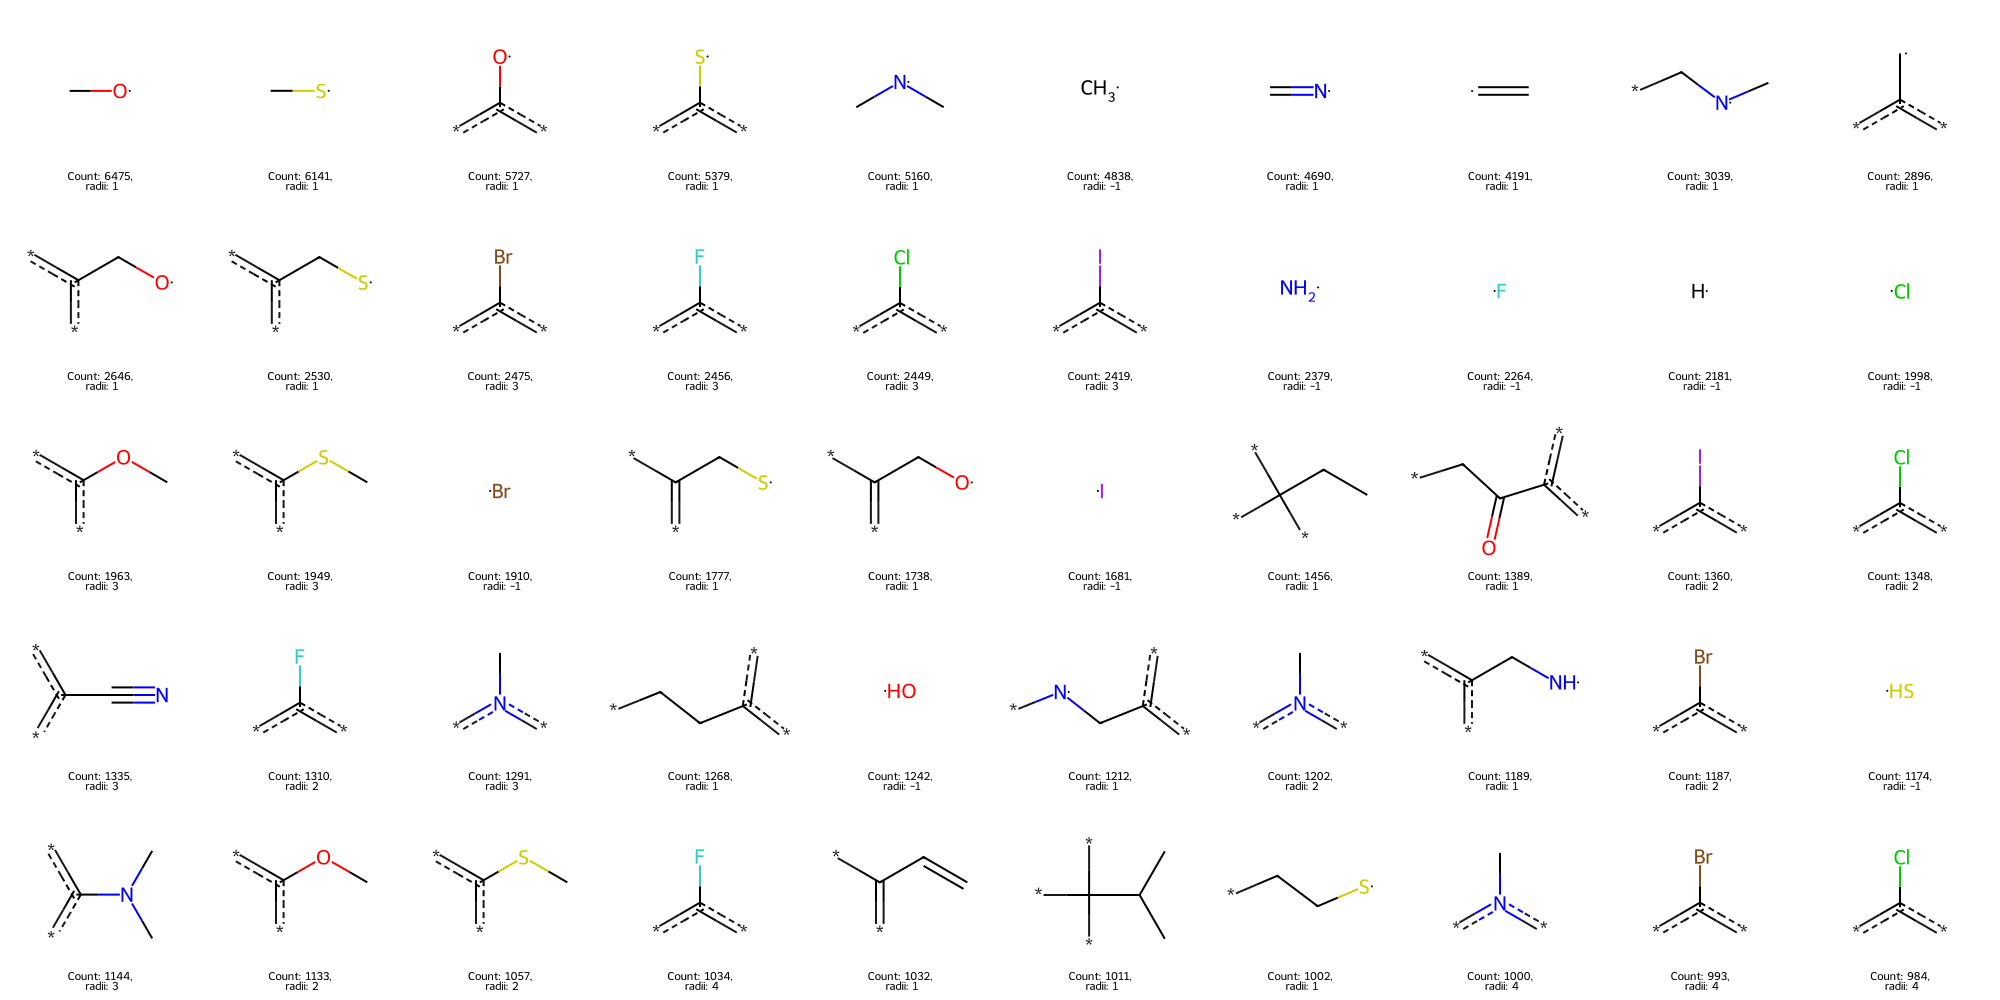

In [5]:
# load substructure_list:
with open("substructures.json", "r") as f:
    substructures_json = json.load(f)

# count substructures and append FIA values:
#substructure_counts = defaultdict(int)
#for i in substructure_list:
#    if i:
#        substructure_counts[i] += 1

# create analysis sets
substructures = defaultdict(lambda: [[], 0])
radii = defaultdict(lambda: [[], 0])
for ligands_props in substructures_json.values():
    # these are the substructures
    for substructs_props in ligands_props[0].values():
        for substruct_props in substructs_props:
            substruct = substruct_props[0]
            radius = int(substruct_props[1])
            substr_rad = (substruct, radius)
            # FIAs
            substructures[substr_rad][0].append(ligands_props[1])
            # counts
            substructures[substr_rad][1] += 1
            # radius set
            radii[radius][0].append(ligands_props[1])
            radii[radius][1] += 1

# sort substructure_counts by counts:
substructures = dict(sorted(substructures.items(), key=lambda item: item[1][1], reverse=True))

# draw substructures:
smiles = [k[0] for k in substructures.keys()]
counts_and_radii = [f"Count: {x[1]},\n radii: {k[1]}" for k, x in substructures.items()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts_and_radii[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

/tmp/ipykernel_2713/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


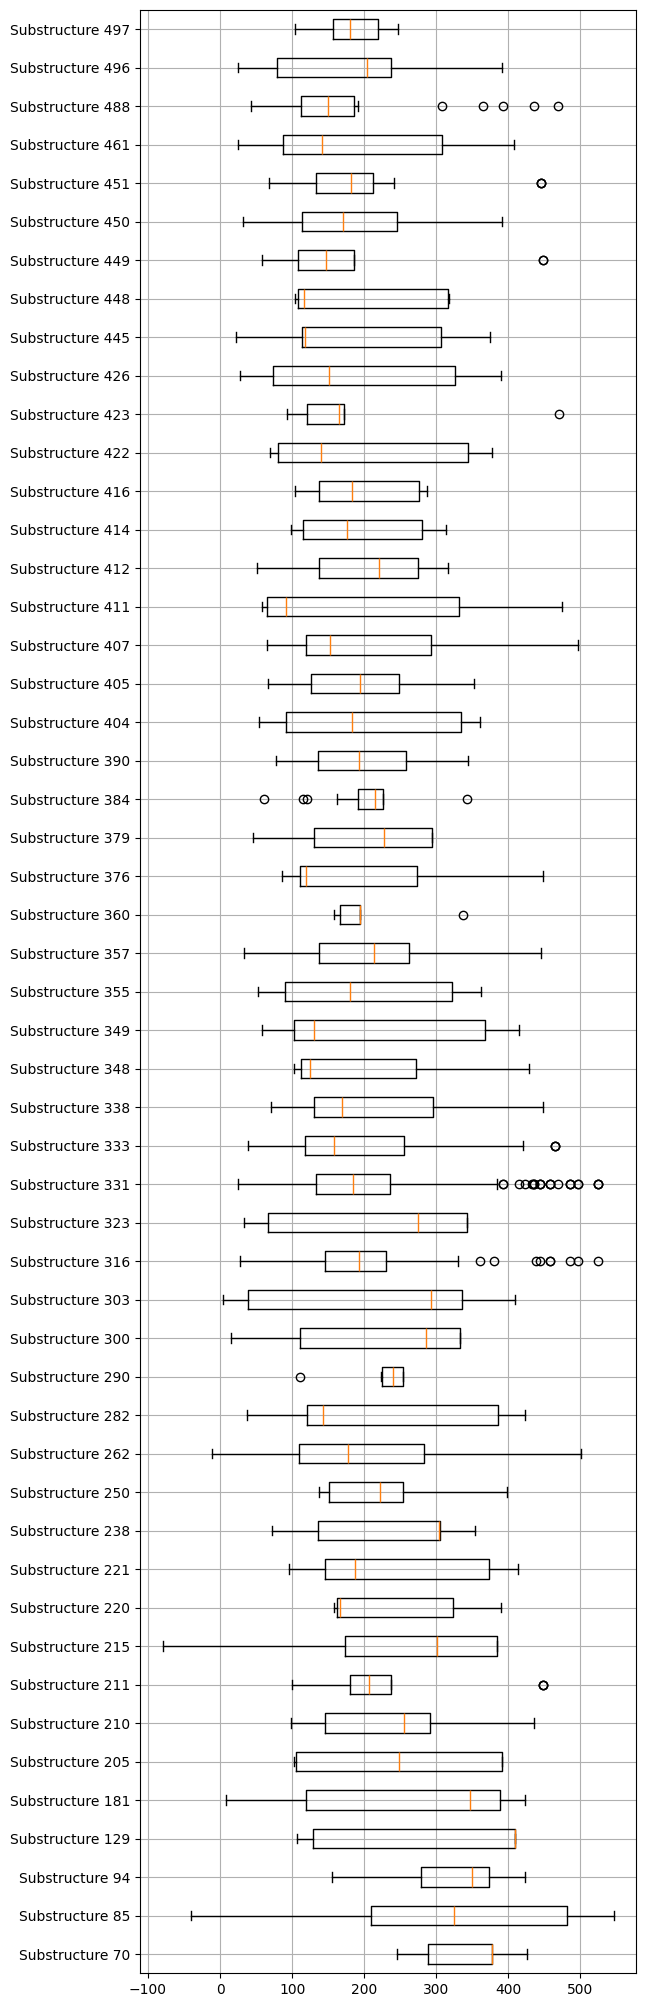

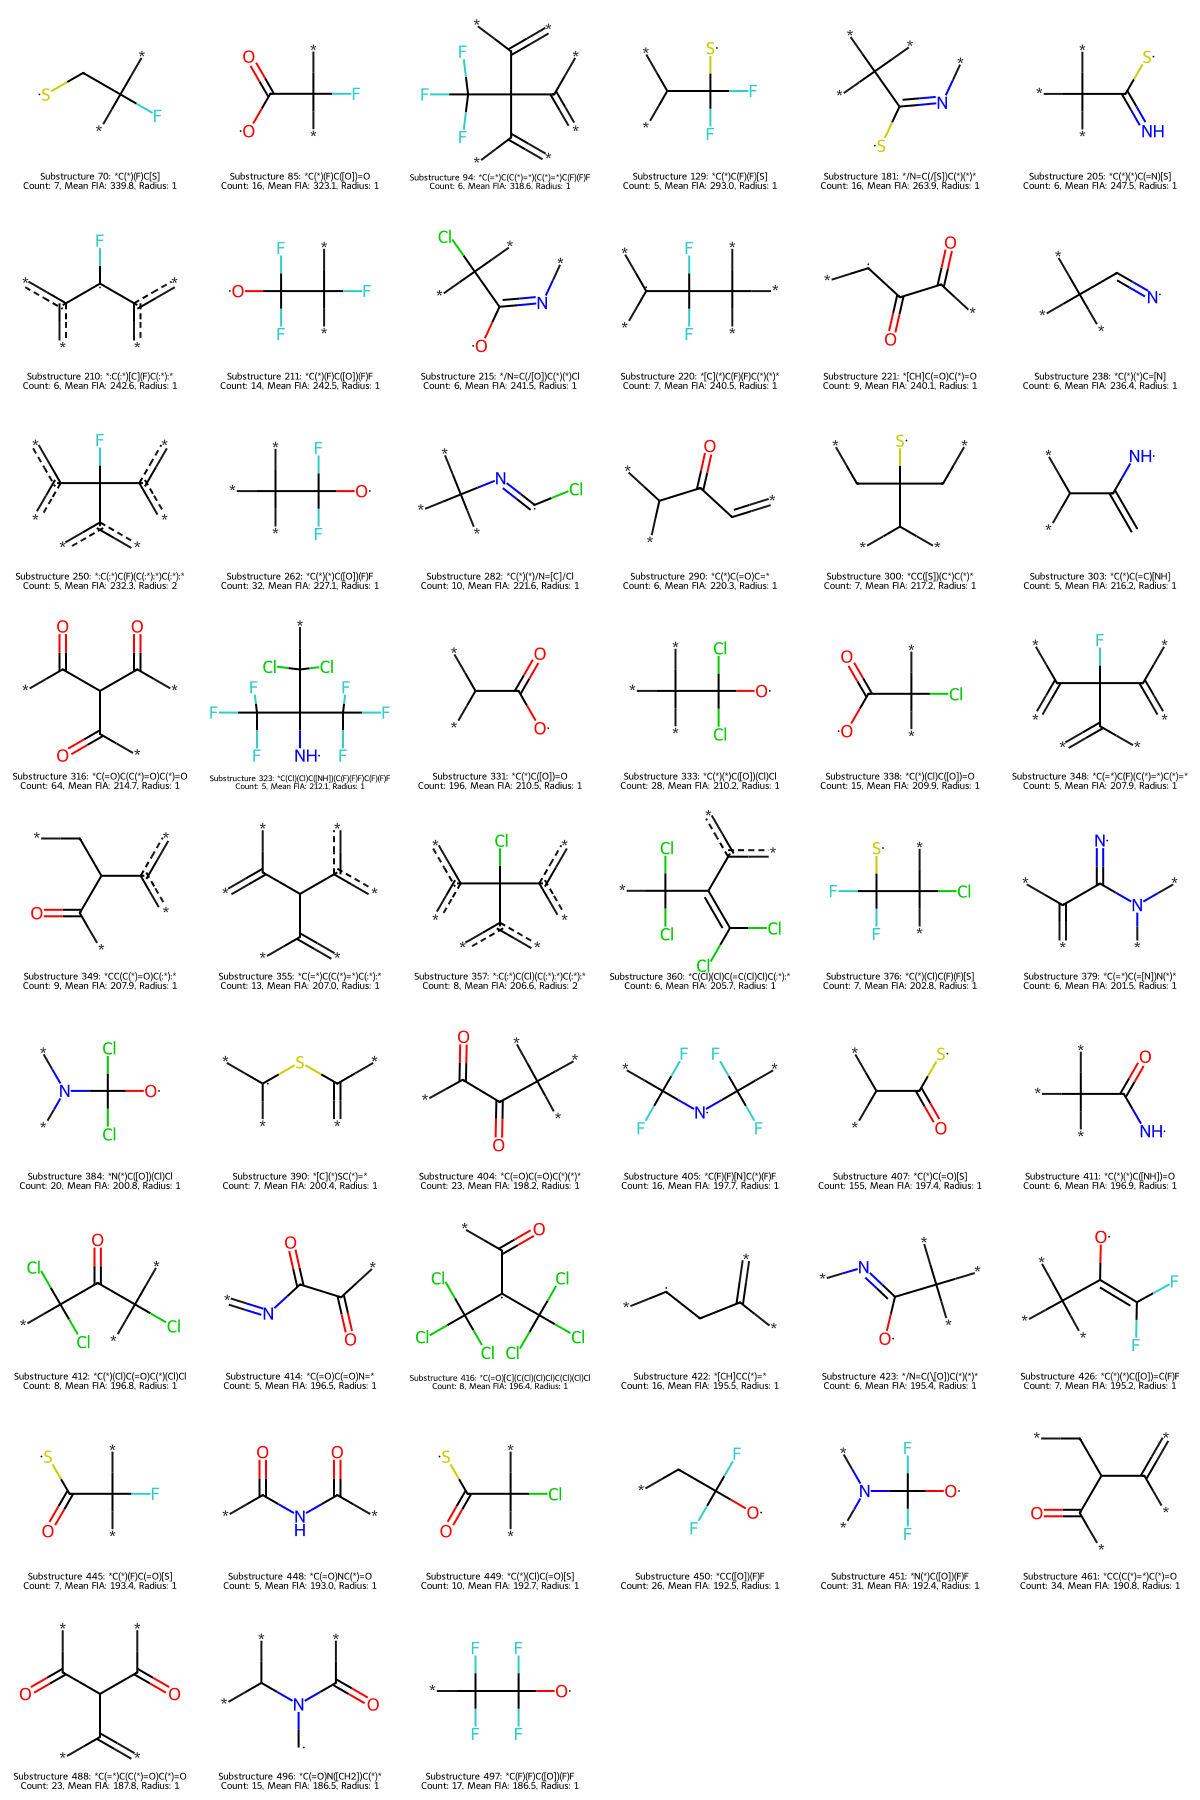

In [6]:
substructures_highest_fia = dict(sorted(substructures.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))
num_highest_fia = 500
min_count = 5

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(substructures_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}")
    legends.append(f"Substructure {i}: {k[0]}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}, Radius: {k[1]}")
    mols.append(Chem.MolFromSmiles(k[0]))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))

/tmp/ipykernel_2713/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


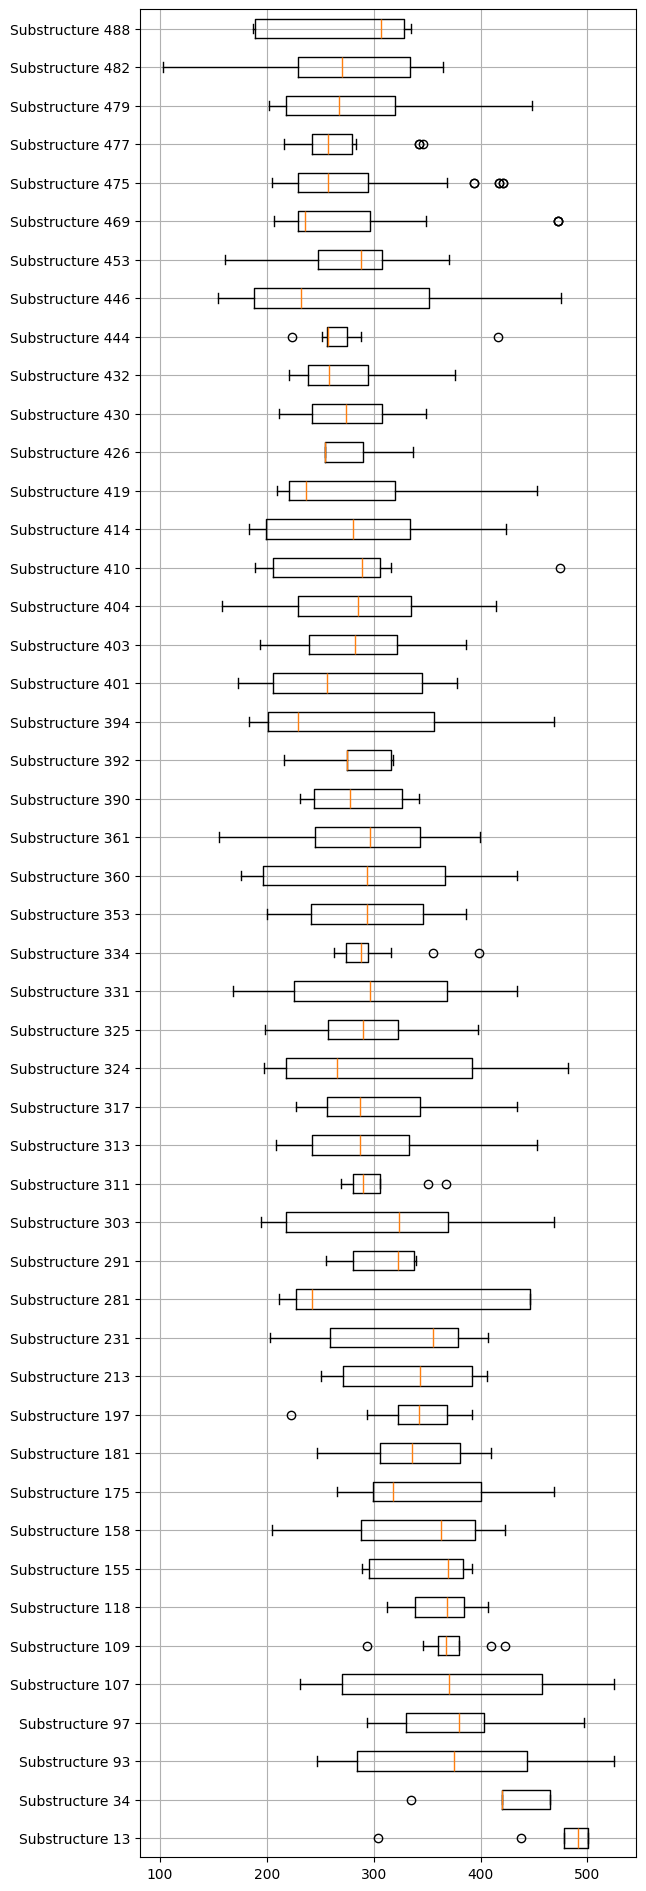

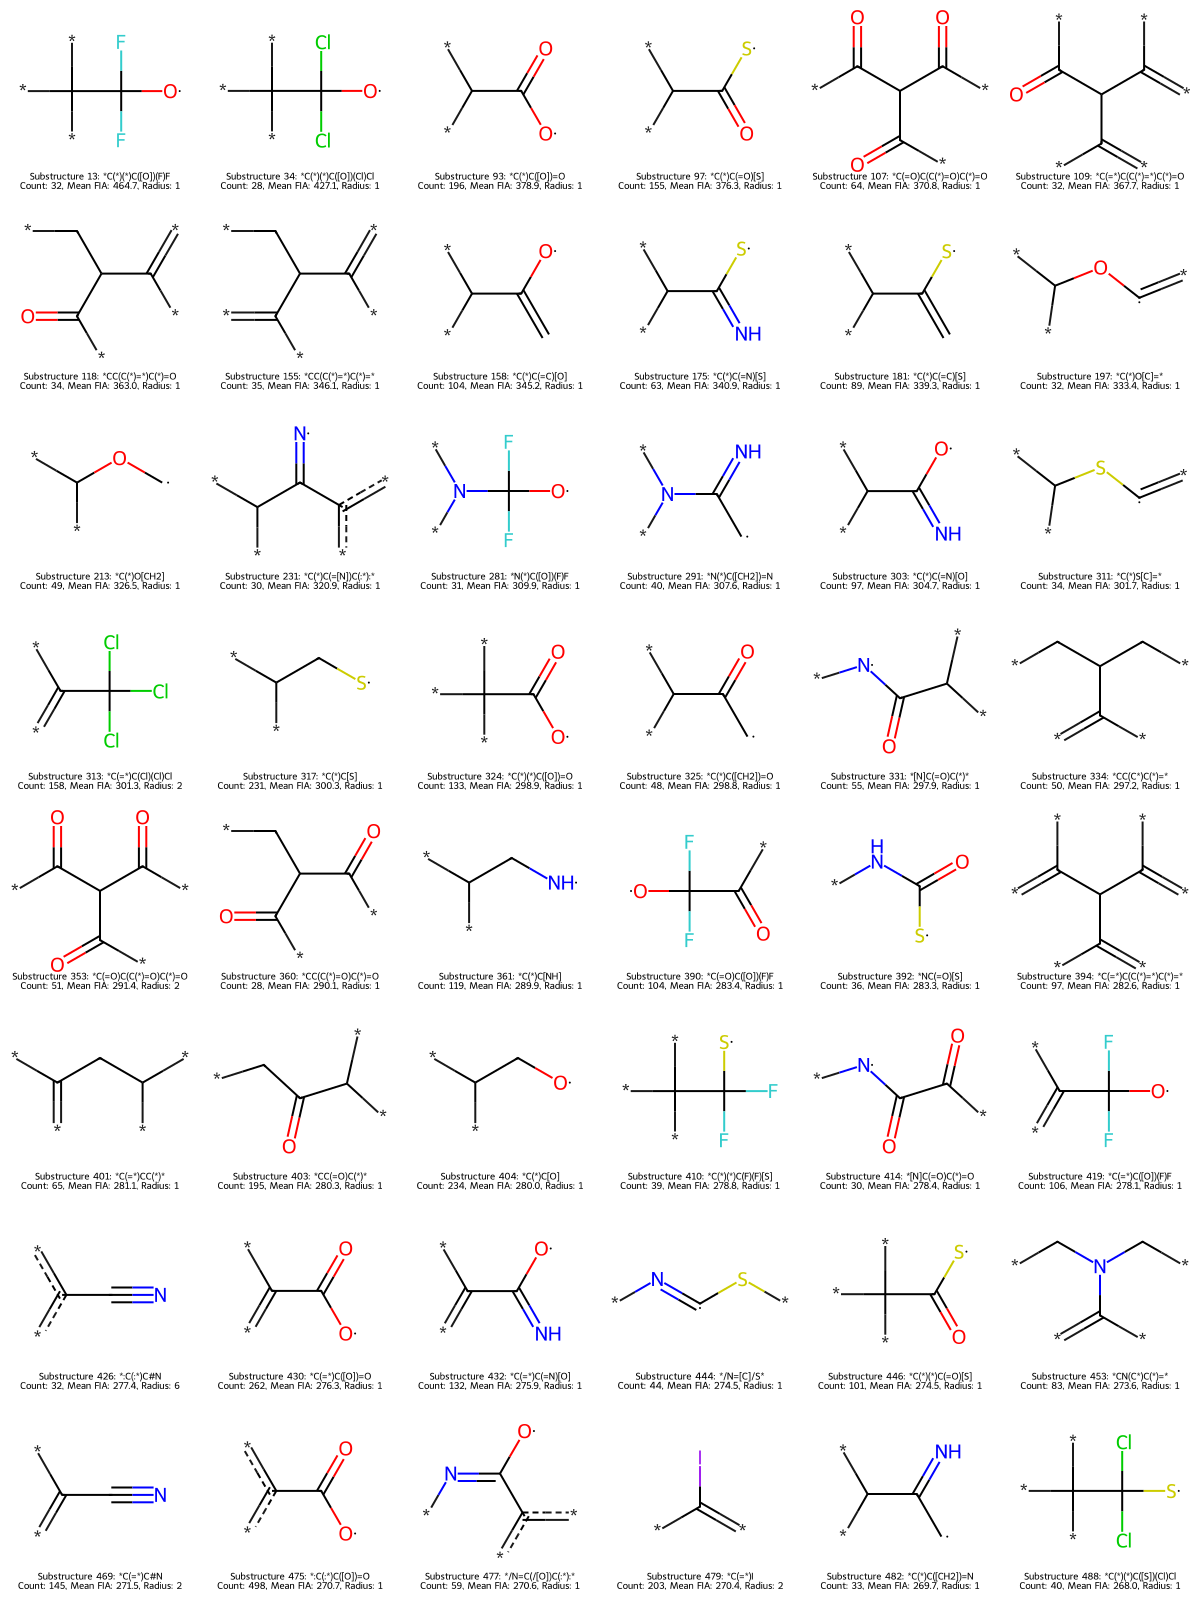

In [7]:
# only consider top 25%
# divide by factor, scale min_count by factor
factor = 4
substructures_partial = deepcopy(substructures)
for substructure, props in substructures_partial.items():
    fia_sorted = sorted(props[0], reverse=True)[:math.ceil(len(props[0]) / factor)]
    substructures_partial[substructure][0] = fia_sorted

for i, (k, v) in enumerate(substructures_partial.items()):
    if v[0] == []:
        raise ValueError(f"Empty at {k}")
substructures_highest_fia = dict(sorted(substructures_partial.items(), key=lambda item: statistics.fmean(item[1][0]), reverse=True))
num_highest_fia = 500
min_count = factor * 7

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(substructures_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}")
    legends.append(f"Substructure {i}: {k[0]}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}, Radius: {k[1]}")
    mols.append(Chem.MolFromSmiles(k[0]))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))

/tmp/ipykernel_2713/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


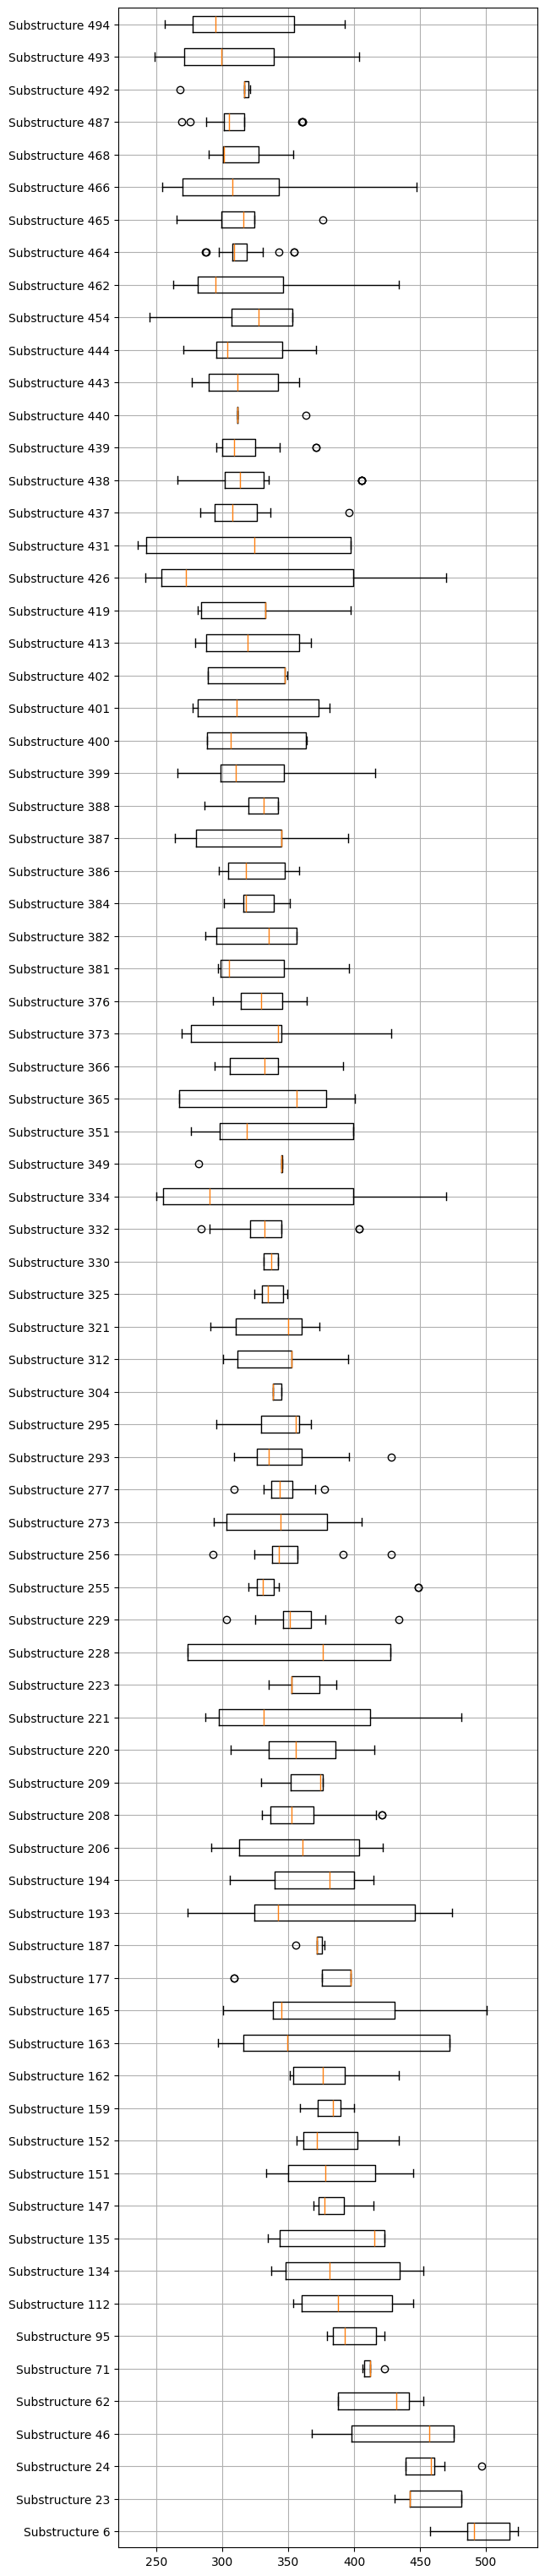

In [8]:
# only consider top 1%
# divide by factor, scale min_count by factor
factor = 20
substructures_partial = deepcopy(substructures)
for substructure, props in substructures_partial.items():
    fia_sorted = sorted(props[0], reverse=True)[:math.ceil(len(props[0]) / factor)]
    substructures_partial[substructure][0] = fia_sorted

for i, (k, v) in enumerate(substructures_partial.items()):
    if v[0] == []:
        raise ValueError(f"Empty at {k}")
substructures_highest_fia = dict(sorted(substructures_partial.items(), key=lambda item: statistics.fmean(item[1][0]), reverse=True))
num_highest_fia = 500
min_count = factor * 5

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(substructures_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}")
    legends.append(f"Substructure {i}: {k[0]}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}, Radius: {k[1]}")
    mols.append(Chem.MolFromSmiles(k[0]))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))

## 1.3 Analyze radius

/tmp/ipykernel_2713/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


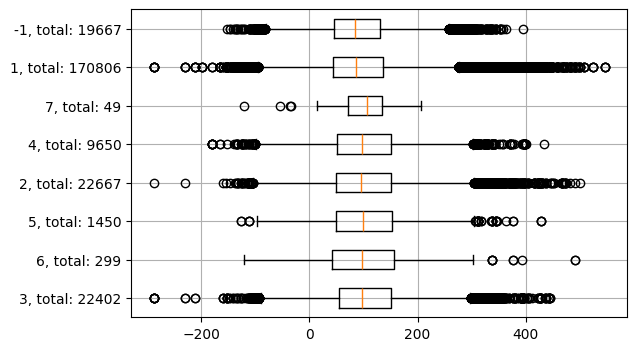

In [14]:
radius_highest_fia = dict(sorted(radii.items(), key=lambda item: statistics.fmean(item[1][0]), reverse=True))

vals = []
labels = []
for k, v in radius_highest_fia.items():
    vals.append(v[0])
    labels.append(f"{k}, total: {len(v[0])}")

draw_boxplots(vals, labels, size = len(labels) / 2)

/tmp/ipykernel_2713/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


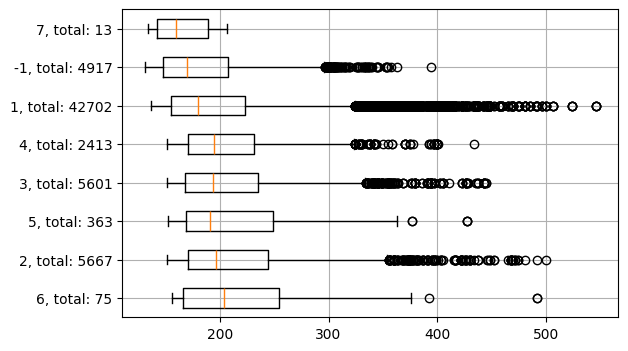

In [15]:
factor = 4
radii_partial = deepcopy(radii)
for radius, props in radii_partial.items():
    fia_sorted = sorted(props[0], reverse=True)[:math.ceil(len(props[0]) / factor)]
    radii_partial[radius][0] = fia_sorted

radius_highest_fia = dict(sorted(radii_partial.items(), key=lambda item: statistics.fmean(item[1][0]), reverse=True))

vals = []
labels = []
for k, v in radius_highest_fia.items():
    vals.append(v[0])
    labels.append(f"{k}, total: {len(v[0])}")

draw_boxplots(vals, labels, size = len(labels) / 2)

/tmp/ipykernel_2713/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


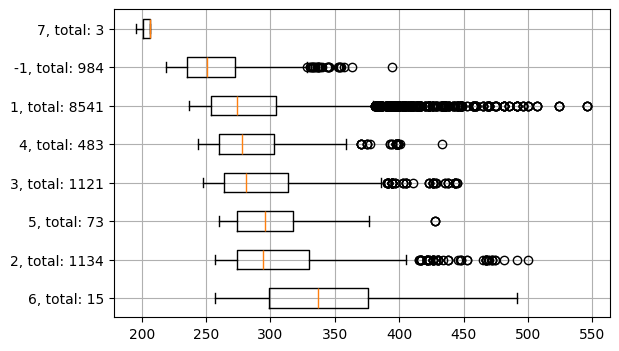

In [17]:
factor = 20
radii_partial = deepcopy(radii)
for radius, props in radii_partial.items():
    fia_sorted = sorted(props[0], reverse=True)[:math.ceil(len(props[0]) / factor)]
    radii_partial[radius][0] = fia_sorted

radius_highest_fia = dict(sorted(radii_partial.items(), key=lambda item: statistics.fmean(item[1][0]), reverse=True))

vals = []
labels = []
for k, v in radius_highest_fia.items():
    vals.append(v[0])
    labels.append(f"{k}, total: {len(v[0])}")

draw_boxplots(vals, labels, size = len(labels) / 2)

# 2. Analyze ring systems

### 2.1 Search for ring systems

In [ ]:
ringsystems = defaultdict(lambda: [[], 0.])

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = ringsystems[row["Compound"]]
    elem[1] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        elem[0].extend(getRingSystemSmiles(Chem.MolFromSmiles(smi)))

with open("ringsystem.json", "w") as f:
    json.dump(ringsystems, f)

### 2.2 Draw ringsystems

In [ ]:
# load substructure_list:
with open("ringsystem.json", "r") as f:
    ringsystems_json = json.load(f)

# two-tuple of list of FIAs and ringsystem count
ringsystems = defaultdict(lambda: [[], 0])
for properties in ringsystems_json.values():
    # these are the substructures
    for substruct in properties[0]:
        ringsystems[substruct][0].append(properties[1])
        ringsystems[substruct][1] += 1

# sort substructure_counts by counts:
ringsystems = dict(sorted(ringsystems.items(), key=lambda item: item[1][1], reverse=True))

# draw substructures:
smiles = list(ringsystems.keys())
counts = [str(x[1]) for x in ringsystems.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

ringsystems_highest_fia = dict(sorted(ringsystems.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 5 

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(ringsystems_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}: {k}")
    legends.append(f"Substructure {i}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))